In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import transformers
from transformers import LayoutLMv2Processor, BertForTokenClassification, AutoTokenizer
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader
from torcheval.metrics.functional import multiclass_f1_score
from src.metrics import confusion_matrix
import seaborn as sns

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.trainer import BertTrainer

In [3]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [4]:
model_name = "bert"
dataset_name = "funsd"

In [5]:
logging.basicConfig(filename='logs/bert_funsd.log', encoding='utf-8', level= logging.INFO)

## Obtaining data

In [6]:
dataset = load_dataset("nielsr/funsd")

In [7]:
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 50
    })
})

In [9]:
n_classes = len(dataset['train'].features['ner_tags'].feature.names)

In [10]:
train_dataset = ImageLayoutDataset(
    dataset['train'],
    bert_tokenizer
)

 17%|█▋        | 25/149 [00:00<00:01, 123.64it/s]

100%|██████████| 149/149 [00:01<00:00, 144.46it/s]


In [11]:
validation_dataset = ImageLayoutDataset(
    dataset['test'],
    bert_tokenizer    
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 126.82it/s]


In [12]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle = True
)

validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=1,
    shuffle = True
)

## Importing model

In [13]:
device = "cuda"

In [14]:
bert = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels = n_classes)
bert.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [15]:
trainer = BertTrainer(
    bert,
)

In [16]:
trainer.compile(
    train_dataloader,
    validation_dataloader,
    n_classes= n_classes,
    device = "cuda"
)

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:49<00:00,  5.00s/it]


In [17]:
best_idx = None
for idx, f1 in enumerate(trainer.history['validation-f1']):
    if f1 == trainer.best_f1:
        best_idx = idx 

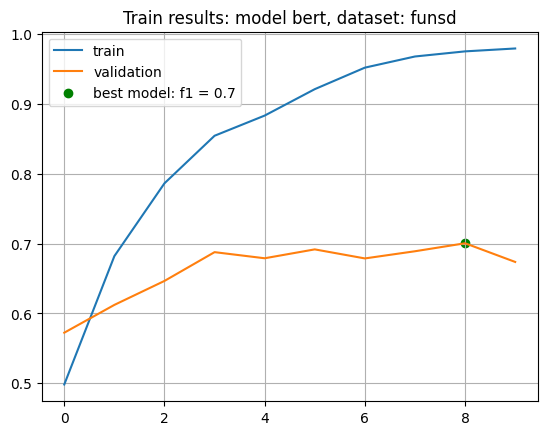

In [18]:
plt.plot(trainer.history['train-f1'],
         label = "train")
plt.plot(trainer.history['validation-f1'],
         label = "validation")

plt.title(f"Train results: model {trainer.model_name}, dataset: {dataset_name}")
plt.scatter(
    best_idx,
    trainer.best_f1.item(), 
    color = "green",
    label = f"best model: f1 = {round(trainer.best_f1.item(), 2)}"
) 
plt.grid()
plt.legend()

In [19]:
trainer.history['validation-f1']

[0.5724959373474121,
 0.6123044490814209,
 0.6466261744499207,
 0.6878356337547302,
 0.679080069065094,
 0.691804826259613,
 0.6788465976715088,
 0.6891197562217712,
 0.7005603313446045,
 0.6738267540931702]

In [20]:
trainer.history['train-f1']

[0.49833396077156067,
 0.6821451783180237,
 0.7864434719085693,
 0.8545220494270325,
 0.8834213614463806,
 0.9212514758110046,
 0.9520648717880249,
 0.9680377840995789,
 0.9753669500350952,
 0.9795089364051819]

## Performance analysis

### Distribution of errors

In [22]:
feature_names = dataset['train'].features['ner_tags'].feature.names
keymap = {i : v for i, v in enumerate(feature_names)}

In [24]:
y_pred, y_true = trainer.evaluate(validation_dataloader)

In [25]:
errors = y_pred[y_pred != y_true ]

In [32]:
conf_matrix = confusion_matrix(
    y_pred,
    y_true,
    n_classes,
    keymap
)

Text(0.5, 1.0, 'Confusion matrix- model: bert, dataset : funsd')

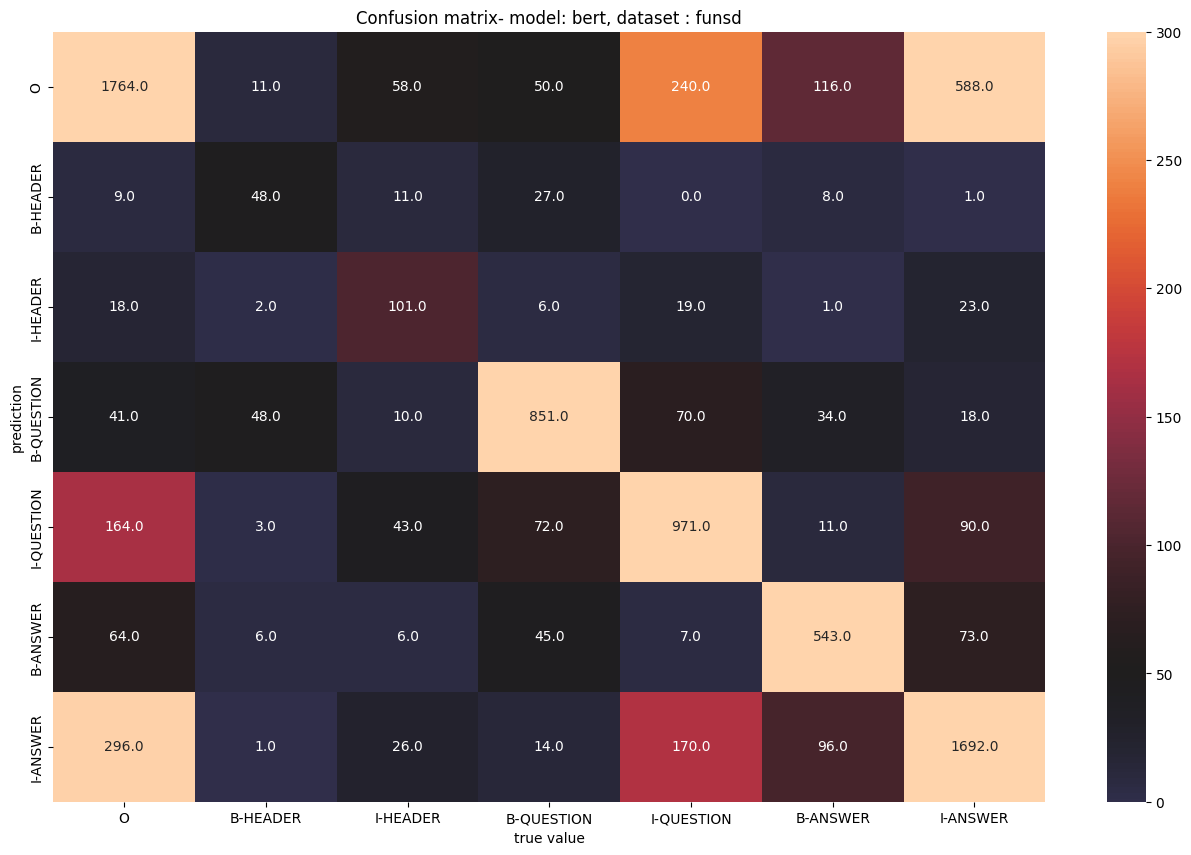

In [37]:

plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix,
            annot=True,
            vmax=300,
            center= 50,
            fmt = '.1f')

plt.title(f"Confusion matrix- model: {model_name}, dataset : {dataset_name}")